# Initial configuration

In [6]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import json

VQG2VQA_RESULTS_PATH = "/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_debug250/llava-1.5-7b-hf/VQG2VQA_ego4d_debug250_llava-1.5-7b-hf_20240701115231/preds_heuristic_val.json"
preds_vqg2vqa = json.load(open(VQG2VQA_RESULTS_PATH, "r"))

SPATIAL_RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_debug250/llava-1.5-7b-hf/VQG2VQA_ego4d_debug250_llava-1.5-7b-hf_spatial1.0_20240701115730/preds_heuristic_val.json"
preds_spatial = json.load(open(SPATIAL_RESULTS_PATH, "r"))

In [20]:
from travel.model.mistake_detection import calculate_abstention_metrics, plot_abstention_metrics, DETECTION_FRAMES_PROPORTION

def get_frame_times(pred):
    frame_times = pred['example']['frame_times']
    cutoff_time = get_cutoff_time_by_proportion(frame_times, DETECTION_FRAMES_PROPORTION)
    frame_times = [t for t in frame_times if t >= cutoff_time]
    return frame_times

def plot_abstention_curve(all_probs, all_labels, result_name, save_path):
    penalty = 1
    thresholds = np.linspace(0.0, 1.0, 101) # [0.0, 0.01, 0.02, 0.03, ..., 0.98, 0.99, 1.0]
    thresholds = [t for t in thresholds if t >= 0.5] # [0.50, 0.51, ..., 0.98, 0.99, 1.0] (only keep thresholds at least 0.5 because every class is predicted with at least 0.5 likelihood in binary classification)

    coverages, risks, eff_reliabilities, sp_recalls = [], [], [], []
    for t in tqdm(thresholds, desc="thresholds"):
        c, r, e, spr, _ = calculate_abstention_metrics(all_probs, [1 if l else 0 for l in all_labels], t, penalty)
        coverages.append(c)
        risks.append(r)
        eff_reliabilities.append(e)
        sp_recalls.append(spr)     
                   
    plot_abstention_metrics(thresholds, coverages, risks, eff_reliabilities, sp_recalls, result_name, [save_path])
                   
    return coverages, risks, eff_reliabilities, sp_recalls

500it [00:00, 10003.49it/s]
thresholds: 100%|██████████| 51/51 [00:00<00:00, 3143.56it/s]


([1.0,
  1.0,
  1.0,
  0.998,
  0.996,
  0.992,
  0.984,
  0.97,
  0.968,
  0.966,
  0.958,
  0.948,
  0.94,
  0.934,
  0.916,
  0.906,
  0.9,
  0.89,
  0.878,
  0.87,
  0.858,
  0.842,
  0.832,
  0.816,
  0.8,
  0.778,
  0.764,
  0.742,
  0.718,
  0.692,
  0.654,
  0.628,
  0.612,
  0.596,
  0.57,
  0.544,
  0.522,
  0.508,
  0.484,
  0.454,
  0.424,
  0.392,
  0.366,
  0.348,
  0.326,
  0.306,
  0.278,
  0.26,
  0.226,
  0.194,
  0.164],
 [0.338,
  0.338,
  0.338,
  0.33867735470941884,
  0.3373493975903614,
  0.3346774193548387,
  0.33739837398373984,
  0.33608247422680415,
  0.3347107438016529,
  0.33540372670807456,
  0.33820459290187893,
  0.339662447257384,
  0.3404255319148936,
  0.3361884368308351,
  0.33624454148471616,
  0.32891832229580575,
  0.3288888888888889,
  0.3303370786516854,
  0.3325740318906606,
  0.335632183908046,
  0.337995337995338,
  0.33966745843230406,
  0.3389423076923077,
  0.33578431372549017,
  0.3325,
  0.3341902313624679,
  0.32460732984293195,
  0.31

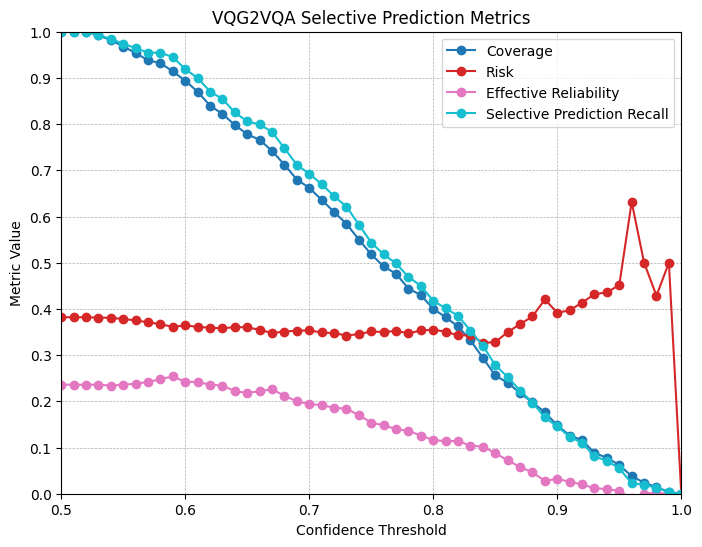

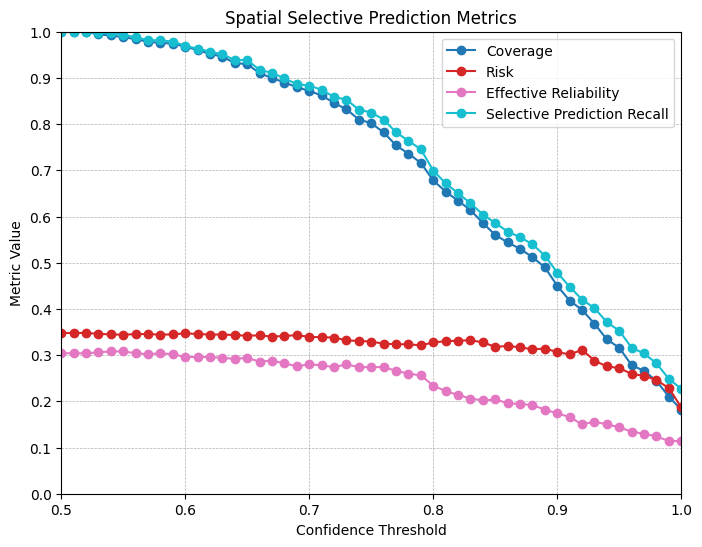

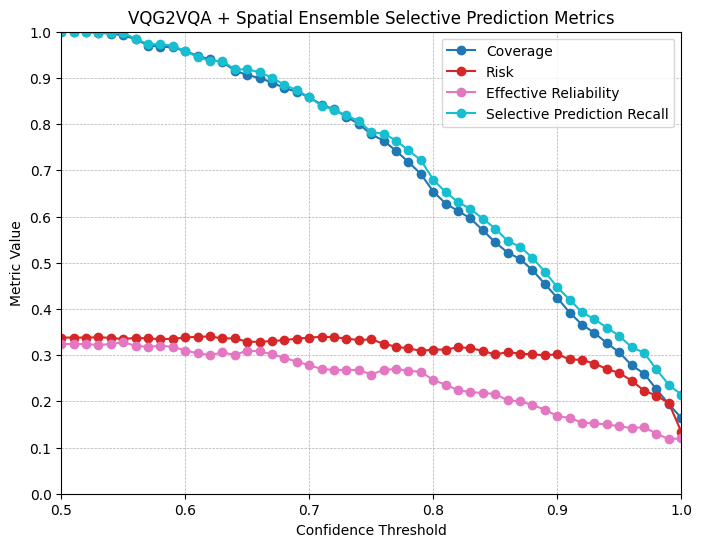

In [21]:
import datetime
import numpy as np
import os
from tqdm import tqdm

from travel.constants import RESULTS_DIR
from travel.data.mistake_detection import get_cutoff_time_by_proportion
from travel.model.mistake_detection import aggregate_mistake_probs_over_frames
   
all_mistake_probs_vqg2vqa = []
all_mistake_probs_spatial = []
all_mistake_probs_combined = []
all_labels = []
for pred_idx, (pred_vqg2vqa, pred_spatial) in enumerate(tqdm(zip(preds_vqg2vqa.values(), preds_spatial.values()))):
    assert pred_vqg2vqa['example']['example_id'] == pred_spatial['example']['example_id']
    frame_times = get_frame_times(pred_vqg2vqa)
            
    mistake_probs_vqg2vqa = pred_vqg2vqa['mistake_detection']["0.0"]['mistake_probs']
    mistake_probs_spatial = pred_spatial['mistake_detection']["0.0"]['mistake_probs']
    mistake_probs_combined = [max(mpv, mps) for mpv, mps in zip(mistake_probs_vqg2vqa, mistake_probs_spatial)]
    
    mistake_prob_vqg2vqa =  aggregate_mistake_probs_over_frames(mistake_probs_vqg2vqa, frame_times)              
    mistake_prob_spatial =  aggregate_mistake_probs_over_frames(mistake_probs_spatial, frame_times)              
    mistake_prob_combined = aggregate_mistake_probs_over_frames(mistake_probs_combined, frame_times)
    
    all_mistake_probs_vqg2vqa.append(mistake_prob_vqg2vqa)
    all_mistake_probs_spatial.append(mistake_prob_spatial)
    all_mistake_probs_combined.append(mistake_prob_combined)                
    
    all_labels.append(1 if pred_vqg2vqa['example']['mistake'] else 0)
             
timestamp = datetime.datetime.now()
results_dir = os.path.join(RESULTS_DIR, "analysis", f"ensemble_vqg2vqa_spatial_{timestamp.strftime('%Y%m%d%H%M%S')}")
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

plot_abstention_curve(all_mistake_probs_vqg2vqa, all_labels, "VQG2VQA", os.path.join(results_dir, "abstention_vqg2vqa.pdf"))
plot_abstention_curve(all_mistake_probs_spatial, all_labels, "Spatial", os.path.join(results_dir, "abstention_spatial.pdf"))
plot_abstention_curve(all_mistake_probs_combined, all_labels, "VQG2VQA + Spatial Ensemble", os.path.join(results_dir, "abstention_combined.pdf"))